# 로지스틱 회귀 (이항분류)

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies, merge
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx", index_col='id')
origin.head()

,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,,,,
1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

> 결측치 없음

### 문제에서 제외하도록 정의한 필드는 제거

In [4]:
df = origin.drop(['Recur_1y', 'OP_date', 'Recur_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   SBP                 156 non-null    float64
 5   CA19.9              156 non-null    float64
 6   CRP                 156 non-null    float64
 7   CEA                 156 non-null    float64
 8   post.CEA            156 non-null    float64
 9   stage               156 non-null    int64  
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  post.CA19.9.3grp    156 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 19.5 KB


## #04. 탐색적 데이터 분석

### 명목형에 대한 데이터 타입 설정

In [5]:
df['sex'] = df['sex'].astype('category')
df['Recur'] = df['Recur'].astype('category')
df['stage'] = df['stage'].astype('category')
df['smoking'] = df['smoking'].astype('category')
df['obesity'] = df['obesity'].astype('category')
df['post.CA19.9.binary'] = df['post.CA19.9.binary'].astype('category')
df['post.CA19.9.3grp'] = df['post.CA19.9.3grp'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 156 non-null    int64   
 1   sex                 156 non-null    category
 2   weight              156 non-null    float64 
 3   Recur               156 non-null    category
 4   SBP                 156 non-null    float64 
 5   CA19.9              156 non-null    float64 
 6   CRP                 156 non-null    float64 
 7   CEA                 156 non-null    float64 
 8   post.CEA            156 non-null    float64 
 9   stage               156 non-null    category
 10  smoking             156 non-null    category
 11  obesity             156 non-null    category
 12  post.CA19.9         156 non-null    float64 
 13  post.CA19.9.binary  156 non-null    category
 14  post.CA19.9.3grp    156 non-null    category
dtypes: category(7), float64(7), int64(1)
memory u

### 기술통계량 확인

In [6]:
df.describe()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


### 상자그림 확인

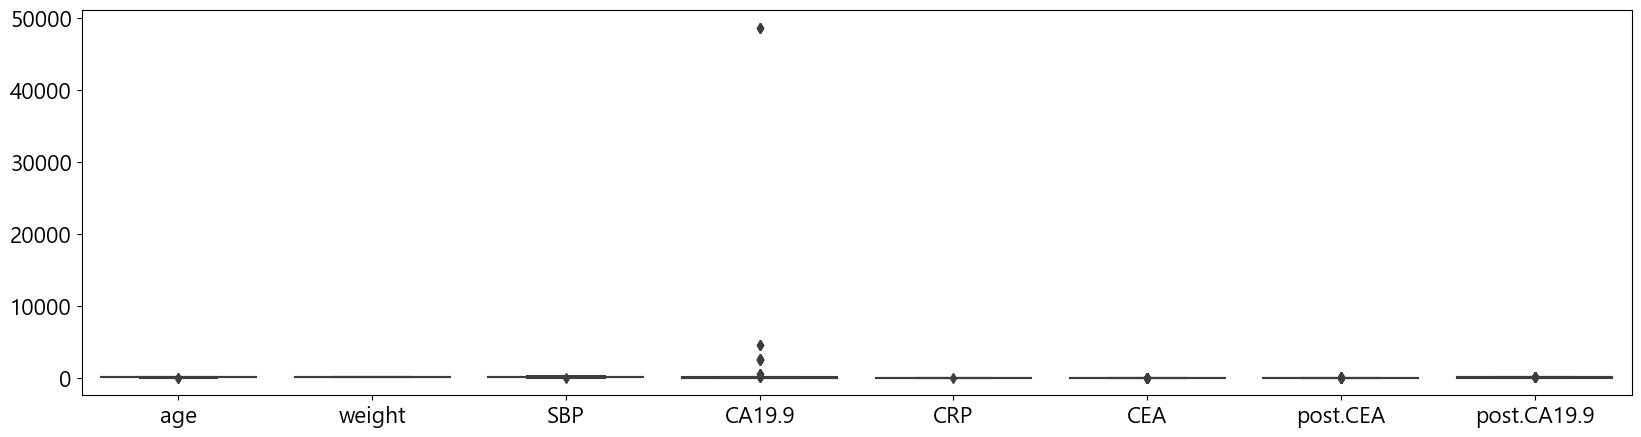

In [7]:
plt.figure(figsize=(20, 5))
sb.boxplot(data=df)
plt.show()
plt.close()

> "CA19.9"에서 약 50000정도의 값이 발견되었음. 이 값을 이상치인지 확인이 필요함

### 이상치 확인

In [8]:
df.query("`CA19.9` > 40000")

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


> 수치가 4만이 넘는 경우가 모두 췌장암 2기로 확인됨(stage==2)

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


> 다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 `CA19.9` 수치가 4만을 넘는 경우를 이상치로 판단하고 제거하기로 함

### 이상치 정제

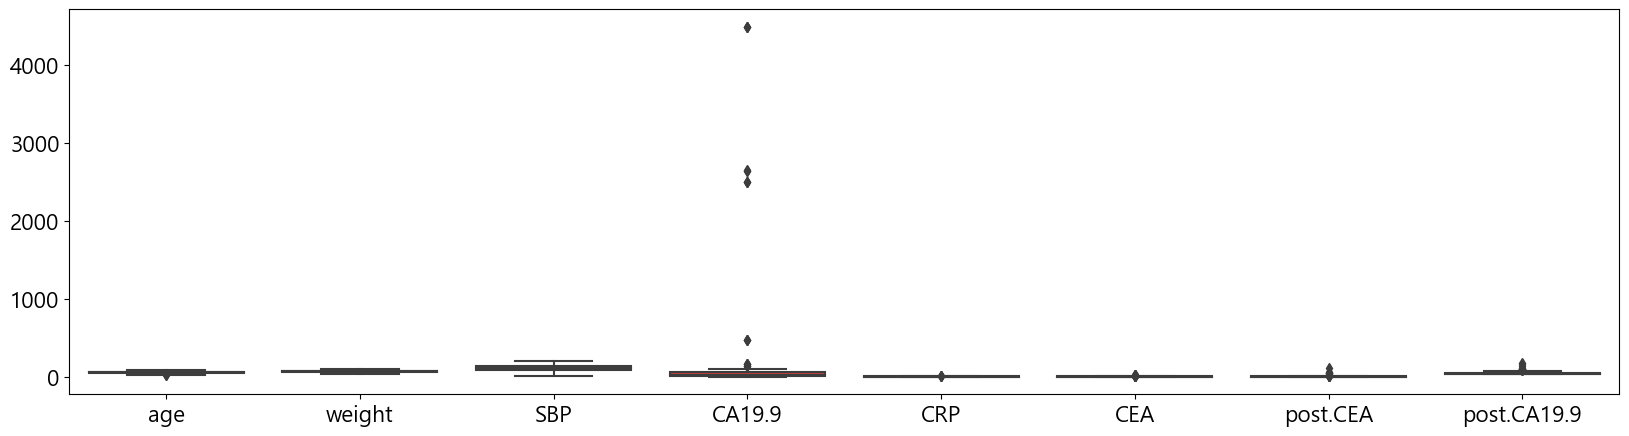

In [10]:
df2 = df.drop(df.query("`CA19.9` > 40000").index)

plt.figure(figsize=(20, 5))
sb.boxplot(data=df2)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [11]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [12]:
x = df2.drop(['Recur'], axis=1)
y = df2['Recur']

x.shape, y.shape

((153, 14), (153,))

### 데이터 표준화

#### 명목형 변수는 더미변수로 변환해야 하므로 데이터를 종류별로 구분

##### 연속형 변수만 추출

In [13]:
x1 = x.drop(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


#### 명목형 변수만 추출

In [14]:
x2 = x.filter(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'])
x2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   sex                 153 non-null    category
 1   stage               153 non-null    category
 2   smoking             153 non-null    category
 3   obesity             153 non-null    category
 4   post.CA19.9.binary  153 non-null    category
 5   post.CA19.9.3grp    153 non-null    category
dtypes: category(6)
memory usage: 2.8 KB


#### 연속형 변수에 대한 표준화

In [19]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x1)
x_scale_df = DataFrame(x_scale, index=x1.index, columns=x1.columns)
x_scale_df.head()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984


#### 명목형 변수를 더미변수로 변환

##### 데이터의 종류가 몇가지인지 확인

데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인됨

In [20]:
x2_dm = get_dummies(x2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
x2_dm.head()

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


### 연속형과 더미변수로 변환된 명목형을 결합

In [21]:
xdf = merge(x_scale_df, x2_dm, left_index=True, right_index=True)
print(xdf.shape)
xdf.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152,1,1,1,0,0,1,0,0
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230,0,1,0,0,0,1,0,0
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126,1,1,0,0,0,1,0,0
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873,1,1,1,0,0,1,0,0
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984,1,1,0,0,0,1,0,0


### 훈련 데이터와 검증 데이터로 분할

In [22]:
x_train, x_test, y_train, y_test = train_test_split(xdf, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107,), (46,))

## #06. 모델 개발

### 모델 정의

In [25]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(16, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [26]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


4/4 [==============================] - 1s 76ms/step - loss: 0.8284 - acc: 0.4486 - val_loss: 0.6432 - val_acc: 0.6087 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.7821 - acc: 0.5047 - val_loss: 0.6297 - val_acc: 0.6739 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7519 - acc: 0.5421 - val_loss: 0.6222 - val_acc: 0.6957 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.7327 - acc: 0.5327 - val_loss: 0.6151 - val_acc: 0.7391 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.7153 - acc: 0.5514 - val_loss: 0.6084 - val_acc: 0.7391 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6977 - acc: 0.5888 - val_loss: 0.6042 - val_acc: 0.7826 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6821 - acc: 0.6075 - val_loss: 0.5997 - val_acc: 0.7609 - lr: 0.0010
Epoch 8/500

## #07. 학습 결과 평가

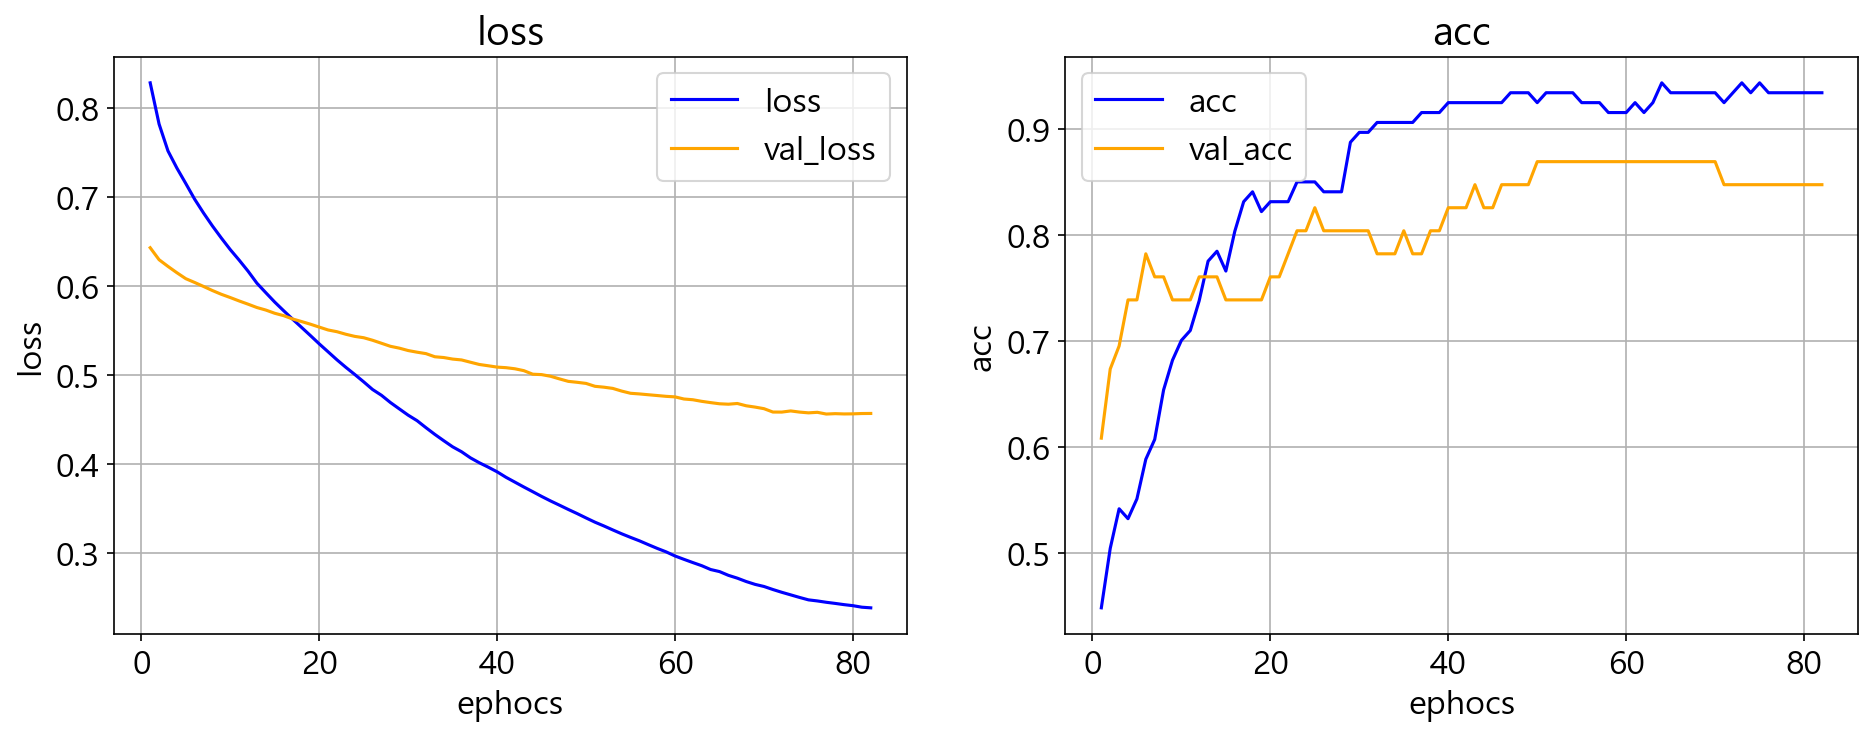

4/4 [==============================] - 0s 4ms/step - loss: 0.2379 - acc: 0.9346
최종 훈련 손실률: 0.237877, 최종 훈련 정확도: 0.934579
2/2 [==============================] - 0s 5ms/step - loss: 0.4571 - acc: 0.8478
최종 검증 손실률: 0.457063, 최종 검증 정확도: 0.847826


In [27]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

#### 혼동행렬

In [28]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)
logit_result.cmdf

4/4 [==============================] - 0s 3ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,Negative,Positive
True,46,6
False,1,54


## #08. 학습 결과 적용

### 예측 결과 산정

In [30]:
train_pred = model.predict(x_train)
train_pred

4/4 [==============================] - 0s 2ms/step


array([[0.9653118 ],
       [0.17799225],
       [0.13374092],
       [0.05087831],
       [0.22453459],
       [0.19575237],
       [0.9400788 ],
       [0.28607515],
       [0.8606215 ],
       [0.26295716],
       [0.23607388],
       [0.7136429 ],
       [0.26214778],
       [0.92212796],
       [0.17344917],
       [0.28675756],
       [0.95917016],
       [0.71820396],
       [0.9233863 ],
       [0.4161513 ],
       [0.9996128 ],
       [0.5436367 ],
       [0.9970252 ],
       [0.9149696 ],
       [0.21707226],
       [0.11963333],
       [0.16170126],
       [0.8101276 ],
       [0.9406561 ],
       [0.40823275],
       [0.2355019 ],
       [0.3132666 ],
       [0.19925137],
       [0.26662812],
       [0.4630781 ],
       [0.9960207 ],
       [0.7334359 ],
       [0.9905767 ],
       [0.93217605],
       [0.8863237 ],
       [0.36815086],
       [0.89614916],
       [0.9671777 ],
       [0.93888   ],
       [0.2497702 ],
       [0.3218953 ],
       [0.5106669 ],
       [0.939

In [31]:
test_pred = model.predict(x_test)
test_pred

2/2 [==============================] - 0s 2ms/step


array([[0.22447838],
       [0.7622516 ],
       [0.11841674],
       [0.2868771 ],
       [0.8617361 ],
       [0.10020176],
       [0.18679379],
       [0.79639506],
       [0.8525758 ],
       [0.27472073],
       [0.8726625 ],
       [0.9306117 ],
       [0.34776902],
       [0.22800858],
       [0.38067973],
       [0.20224832],
       [0.7793091 ],
       [0.37810537],
       [0.3158125 ],
       [0.26884434],
       [0.0560155 ],
       [0.21921614],
       [0.53867084],
       [0.48805466],
       [0.75769866],
       [0.20344758],
       [0.22536927],
       [0.926542  ],
       [0.6492827 ],
       [0.96104026],
       [0.9263877 ],
       [0.6440859 ],
       [0.9819366 ],
       [0.9998691 ],
       [0.5964854 ],
       [0.60781294],
       [0.20815645],
       [0.2456489 ],
       [0.67694265],
       [0.93362135],
       [0.19475874],
       [0.14405258],
       [0.20158167],
       [0.2960929 ],
       [0.96367025],
       [0.62354726]], dtype=float32)

### 결과 데이터 셋 구성

In [40]:
train_pred_bin = (train_pred.flatten() > 0.5).astype(int)
train_pred_bin

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [41]:
train_result_df = DataFrame({'y_train': y_train, 'train_pred': train_pred_bin})
train_result_df

,y_train,train_pred
id,,
126,1,1
155,0,0
133,0,0
134,0,0
103,0,0
...,...,...
74,1,1
90,0,0
61,1,0


In [43]:
train_result_df['result'] = train_result_df['y_train'] == train_result_df['train_pred']
train_result_df

,y_train,train_pred,result
id,,,
126,1,1,True
155,0,0,True
133,0,0,True
134,0,0,True
103,0,0,True
...,...,...,...
74,1,1,True
90,0,0,True
61,1,0,False


In [45]:
train_value_counts = train_result_df['result'].value_counts()
train_value_counts

result
True     100
False      7
Name: count, dtype: int64

result
True     39
False     7
Name: count, dtype: int64

,Train,Test
Success,100,39
Fail,7,7


### 실제 결과값과 머신러닝에 의한 예측값 비교

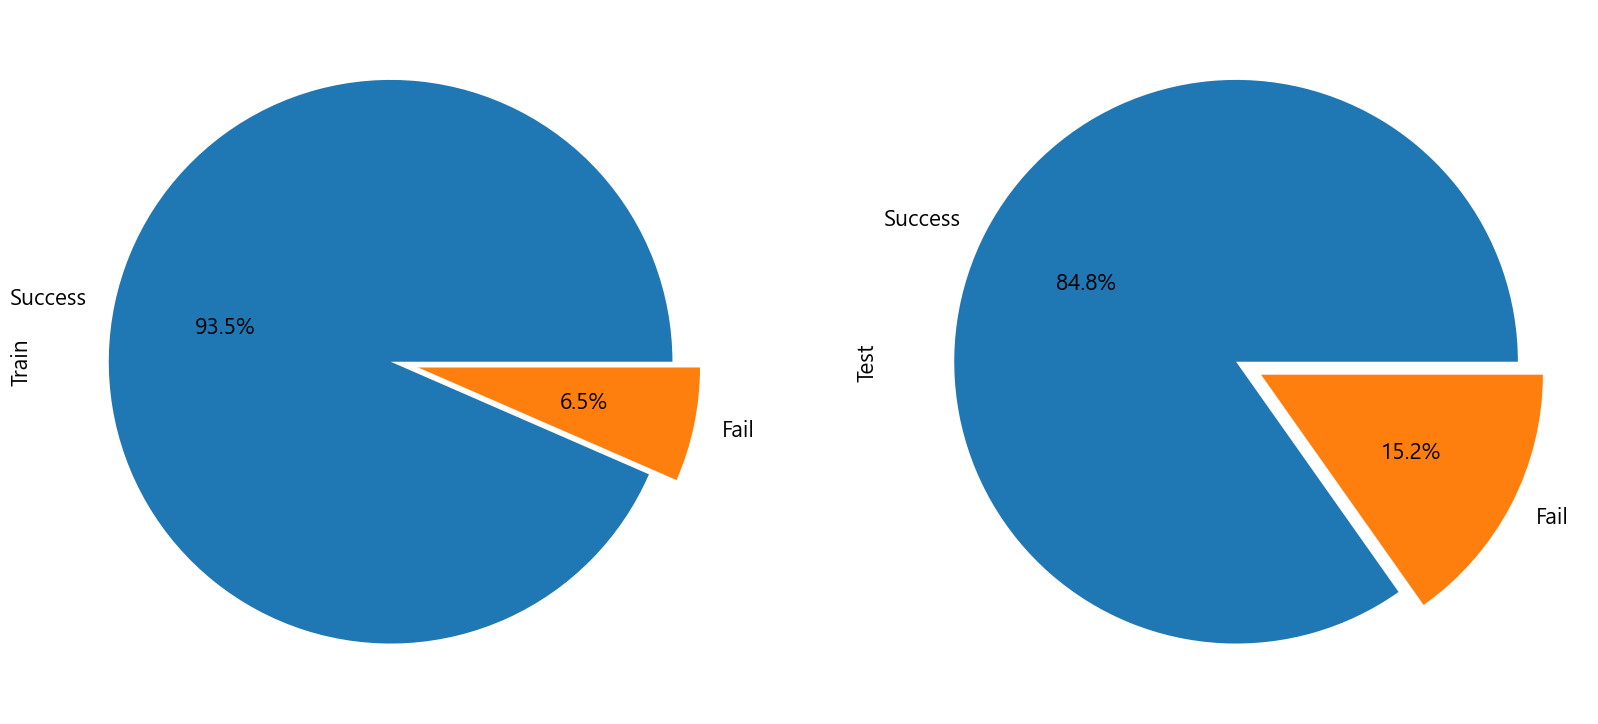